In [ ]:
# Mount Google Drive
# This is just for Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Set the directory at MyDrive
# This is just when running on Google colab
import os
os.chdir('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import copy
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy import interpolate
from scipy.interpolate import NearestNDInterpolator


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import copy
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy import interpolate
from scipy.interpolate import NearestNDInterpolator

# Load the training data (BScans)
# np.shape(train) = (number of samples, 230, 230)
# The Bscans are already normalised
train = np.load('Bscan_Kaggle.npy')

# Load the labels (permittivity ground truth)
# np.shape(labels) = (number of samples, 224, 224)
labels = np.load('Labels_Kaggle.npy')


for i, c in enumerate(train):
    # Go through my training data i.e. BScans
    # Normalise them from -1 to 1
    train[i] = c/np.max(np.abs(c))
    # Normalise the labels from -0.5 to 0.5
    labels[i] = labels[i]/10 - 0.5

    # plt.imshow(labels[i])
    # plt.colorbar()
    # plt.show()


In [ ]:
from tensorflow.keras.layers import ZeroPadding2D, BatchNormalization
from tensorflow.keras.initializers import he_normal



def unet_model(input_size=(230, 230, 1)):
    # This is a vanilla typical U-net that takes an image as input with 230x230 dimensions and gives another image as an output with 224x224 dimensions
    # The hyperparameters are not tuned.


    inputs = Input(input_size)

    # Size of the kernels
    ra=4
    # Encoding path
    c1 = Conv2D(16, (ra, ra), activation='relu', padding='same', kernel_initializer=he_normal())(inputs)
    # c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (ra, ra), activation='relu', padding='same', kernel_initializer=he_normal())(c1)
    # c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(p1)
    # c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c2)
    # c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(p2)
    # c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c3)
    # c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(p3)
    # c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c4)
    # c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(p4)
    # c5 = BatchNormalization()(c5)

    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c5)
    # c5 = BatchNormalization()(c5)

    # Decoding path
    u6 = UpSampling2D((2, 2))(c5)
    # c4 = Cropping2D(cropping=((1, 0), (1, 0)))(c4)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(u6)
    # c6 = BatchNormalization()(c6)

    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c6)
    # c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)

    c3 = Cropping2D(cropping=((1, 0), (1, 0)))(c3)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(u7)
    # c7 = BatchNormalization()(c7)

    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c7)
    # c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    c2 = Cropping2D(cropping=((2, 1), (2, 1)))(c2)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(u8)
    # c8 = BatchNormalization()(c8)

    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c8)
    # c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    c1 = Cropping2D(cropping=((3, 3), (3, 3)))(c1)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(u9)
    # c9 = BatchNormalization()(c9)

    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (ra, ra), activation='relu', padding='same',kernel_initializer=he_normal())(c9)
    # c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='linear')(c9)
    # outputs = UpSampling2D((2, 2))(c10)


    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:

# Divide the data in training and testing. We use 10% for testing purposes.
x_train, x_test, y_train, y_test = train_test_split(train[:,:,:], labels[:,:,:], test_size = 0.1)

# We increase the dimensions by 1 to be consisted with the tensorflow format
x_train = x_train[...,np.newaxis]
y_train = y_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]
y_test = y_test[...,np.newaxis]

# The size of the Bscans i.e. the inputs of the U-net
input_size = (230, 230, 1)
# Initialise the unet
model = unet_model(input_size)

# You can play with the loss, instead of using a typucal mse or mae you can add e.g. a total variational constrain to force the model to be blocky
def custom_loss(y_true, y_pred):
    # Mean Absolute Error
    mae = tf.math.reduce_mean(tf.math.abs(y_true - y_pred))

    # Mean Absolute Differences
    # reg=tf.math.reduce_mean(tf.math.abs(y_pred[1:]-y_pred[:-1]))

    # return mae + reg*0.001

    return mae



# Generate 10 models to apply ensemble U-nets
for i in range(0,1):
    model = unet_model(input_size)
    # Compile the model
    model.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])

    # You can play with this parameter. Usually learning rate of adam should decrease as the iterations increase
    model.optimizer.learning_rate = 5e-4

    # The model with the best performance in the validation set will be saved in best_model_2_1.hp5
    p1 = EarlyStopping(monitor="val_loss", mode= "min", verbose=1, patience=30)
    p2 = ModelCheckpoint('best_model_2_{}.keras'.format(i), monitor="val_loss", mode="min", save_best_only=True )

    # Train the model with 5 batch size for 15 epochs
    history = model.fit(x_train, y_train, epochs=55, batch_size=5, validation_split=0.1, callbacks=[p1, p2])

    # Decrease the learning rate and train for another 10 epochs
    model.optimizer.learning_rate = 1e-4
    history = model.fit(x_train, y_train, epochs=30, batch_size=5, validation_split=0.1, callbacks=[p1, p2])

    # Decrease the learning rate and traing for another 10 epochs
    model.optimizer.learning_rate = 5e-5
    history = model.fit(x_train, y_train, epochs=30, batch_size=5, validation_split=0.1, callbacks=[p1, p2])





Epoch 1/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - loss: 0.1673 - mae: 0.1673 - val_loss: 0.1592 - val_mae: 0.1592
Epoch 2/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1568 - mae: 0.1568 - val_loss: 0.1497 - val_mae: 0.1497
Epoch 3/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1480 - mae: 0.1480 - val_loss: 0.1379 - val_mae: 0.1379
Epoch 4/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1378 - mae: 0.1378 - val_loss: 0.1359 - val_mae: 0.1359
Epoch 5/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1311 - mae: 0.1311 - val_loss: 0.1318 - val_mae: 0.1318
Epoch 6/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1262 - mae: 0.1262 - val_loss: 0.1269 - val_mae: 0.1269
Epoch 7/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.1206 - mae: 0.1206 - val_loss: 0.1149 - val_mae: 0.1149
Epoch 8/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.1159 - mae: 0.1159 - val_loss: 0.1143 - val_mae: 0.1143
Epoch 9/55
713/713 ━━━━━━━━━━━━━━━━━━━━ 

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step
1.1522508662968285


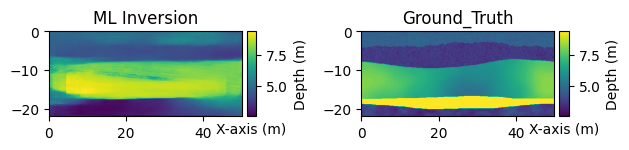

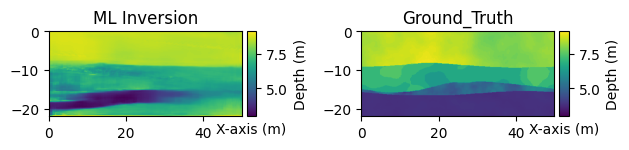

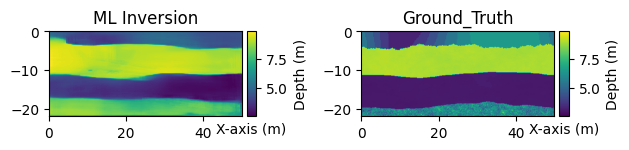

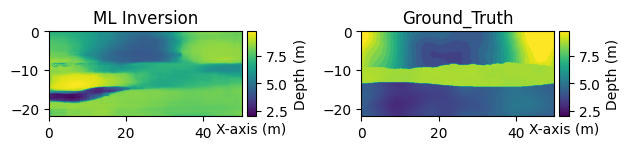

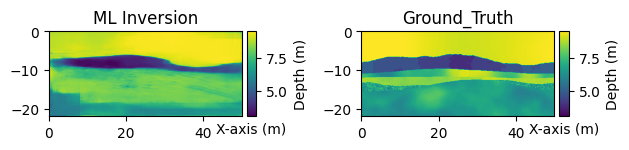

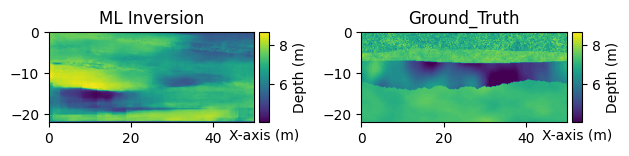

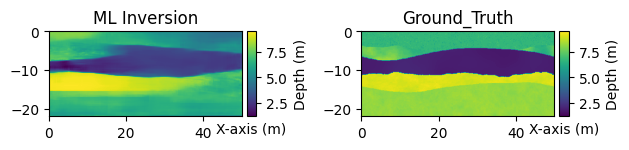

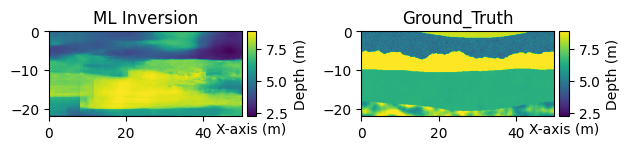

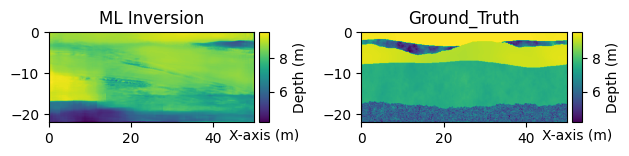

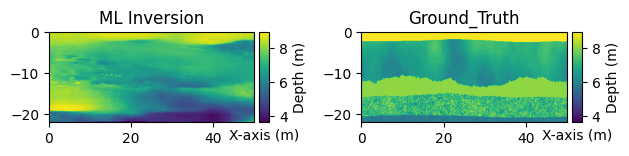

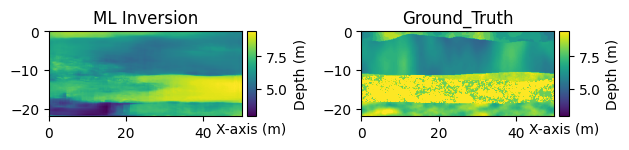

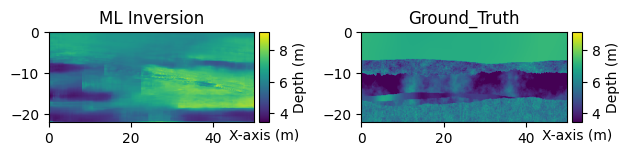

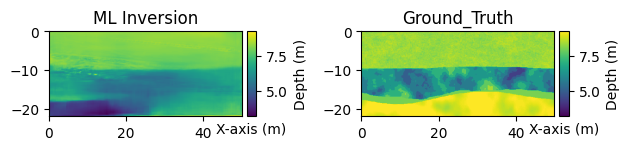

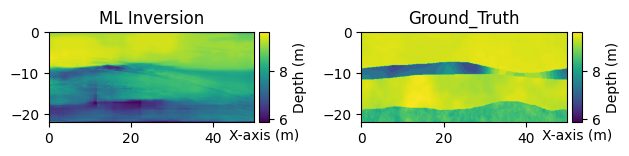

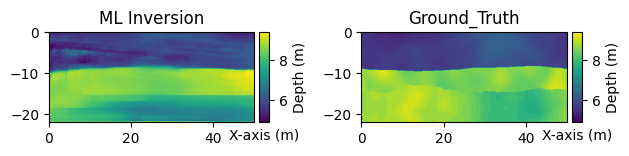

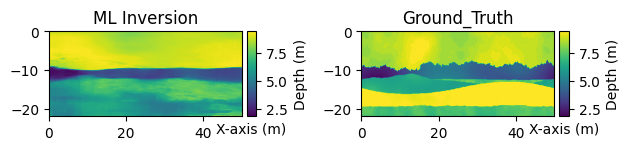

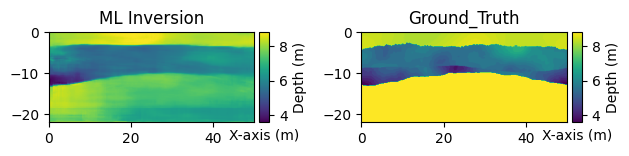

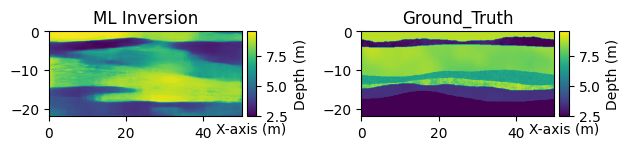

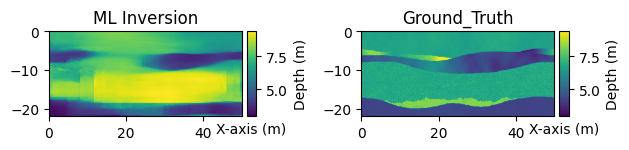

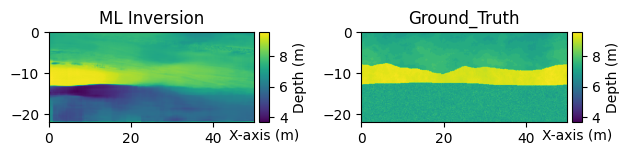

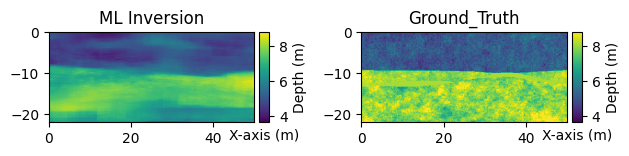

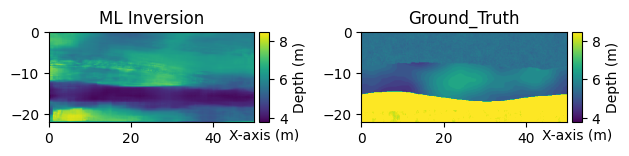

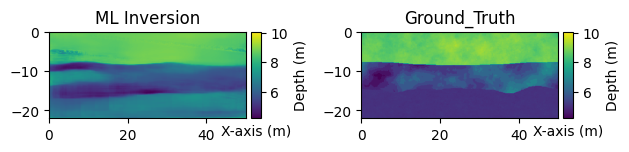

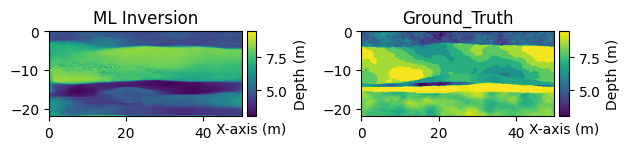

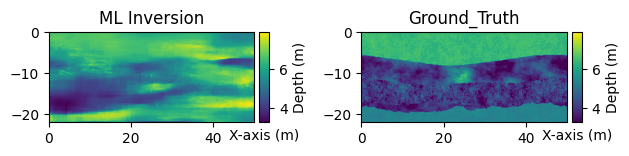

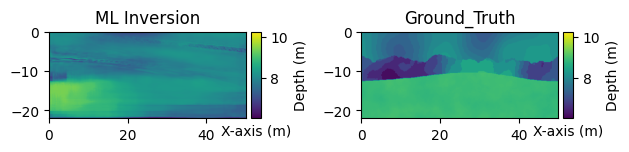

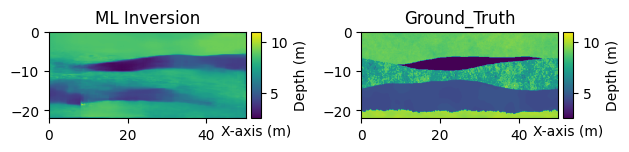

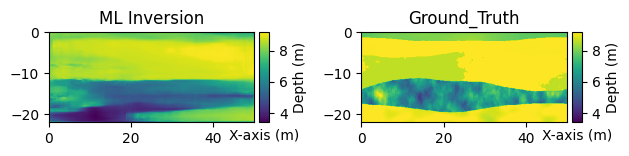

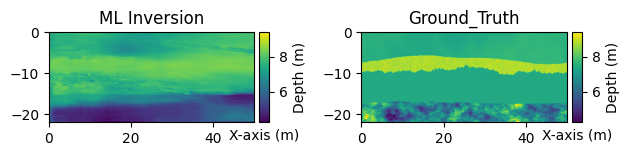

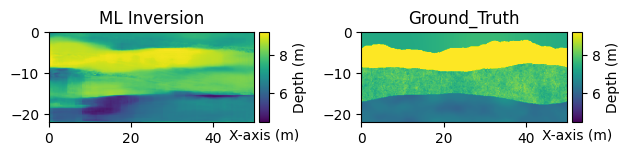

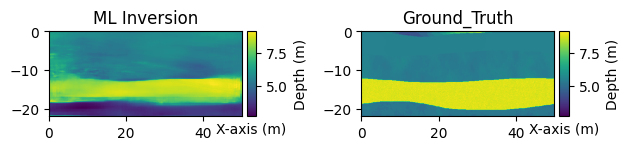

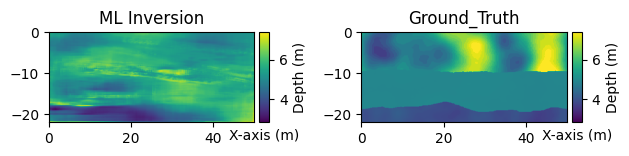

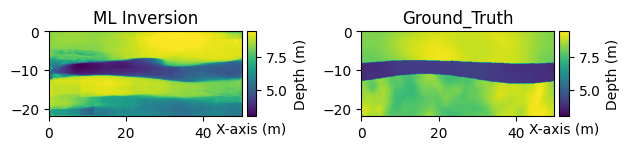

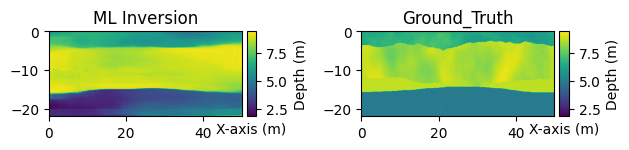

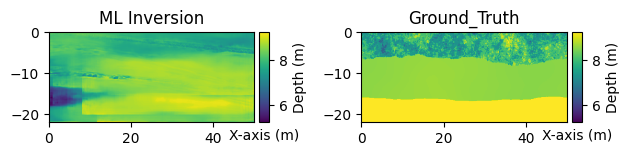

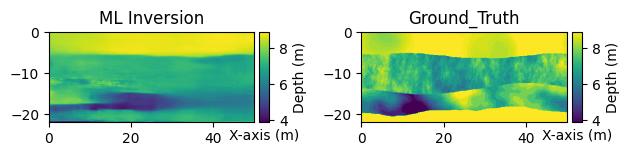

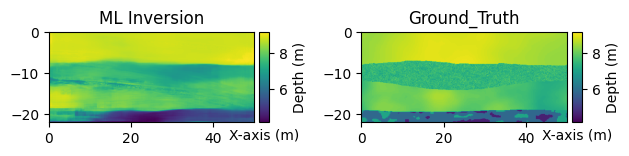

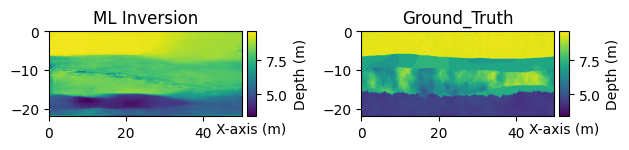

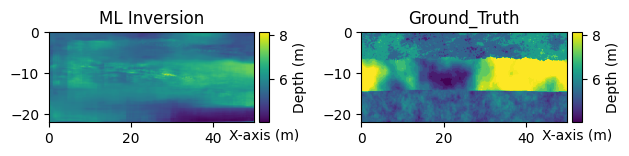

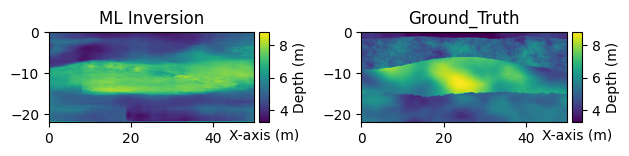

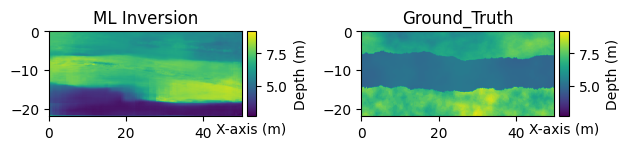

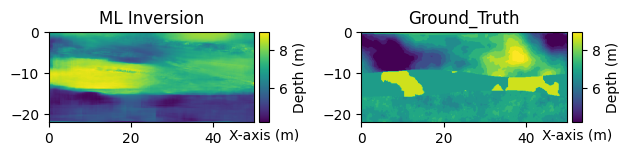

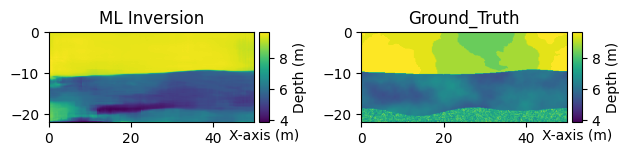

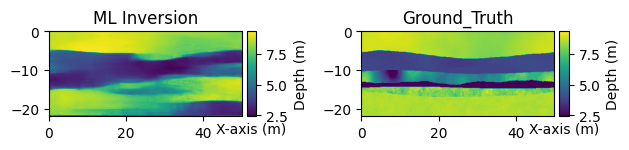

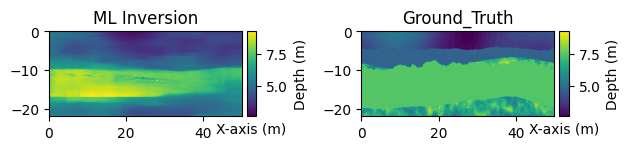

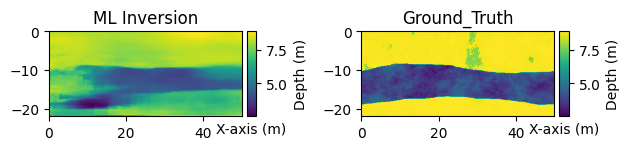

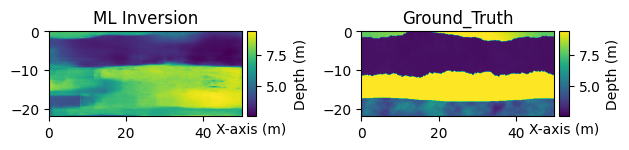

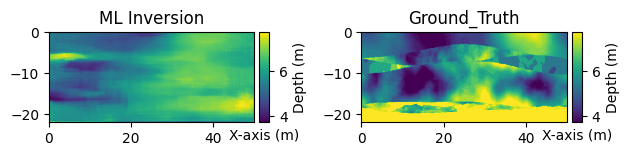

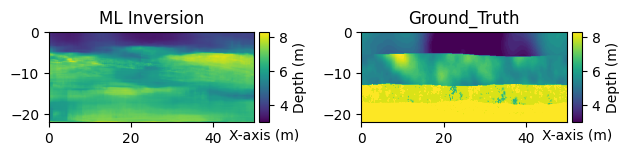

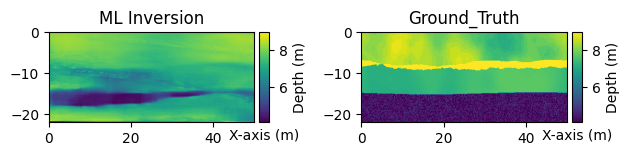

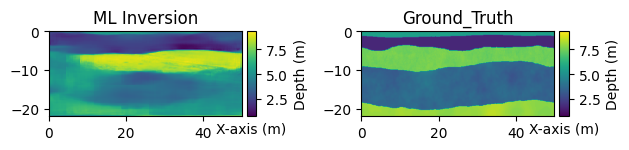

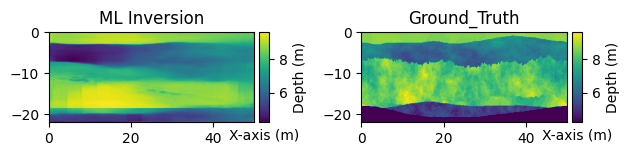

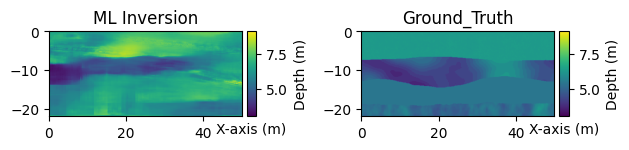

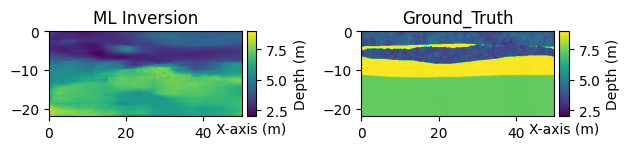

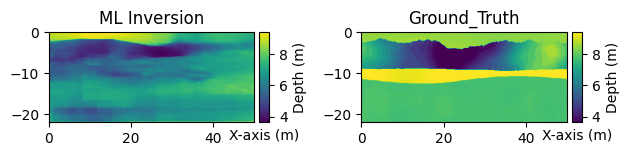

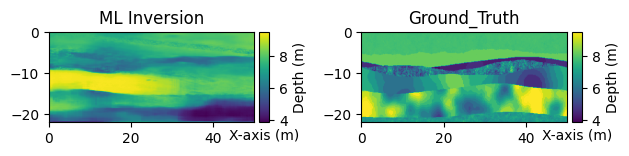

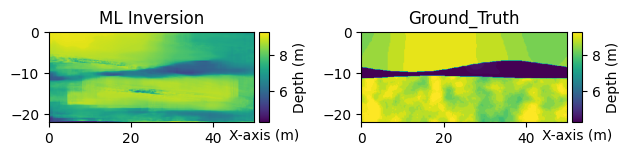

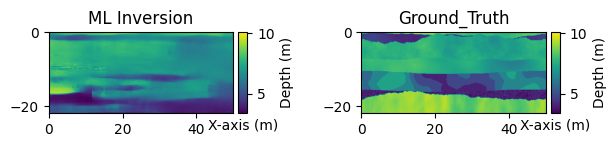

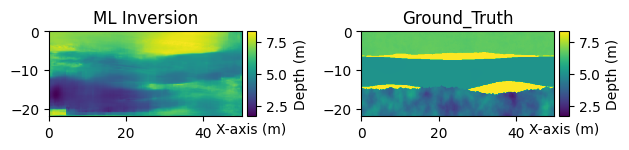

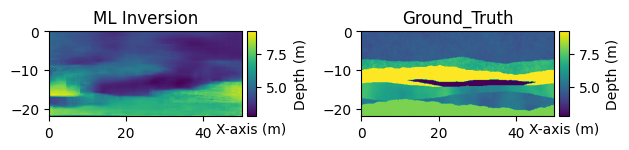

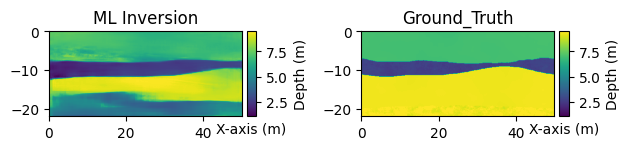

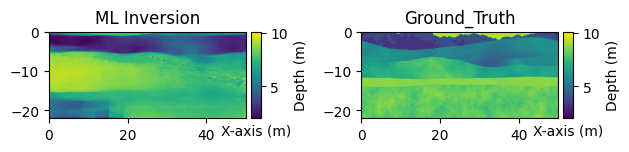

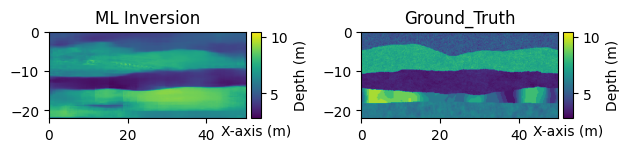

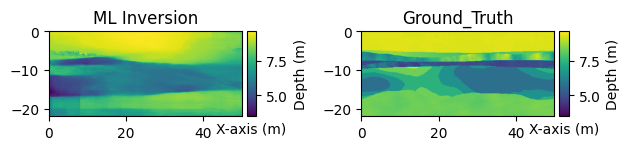

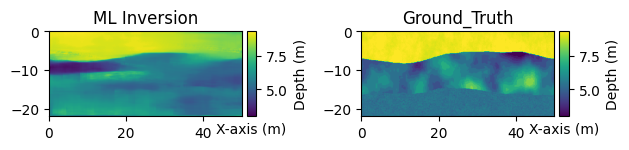

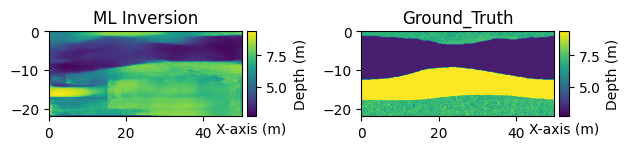

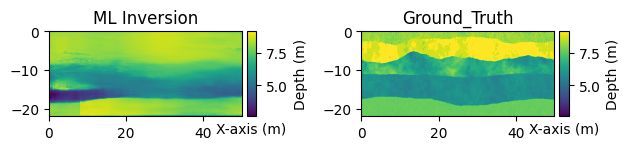

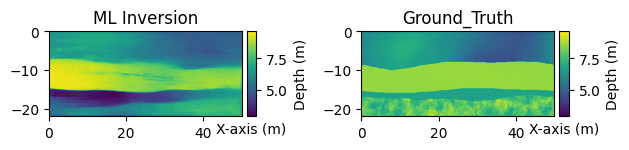

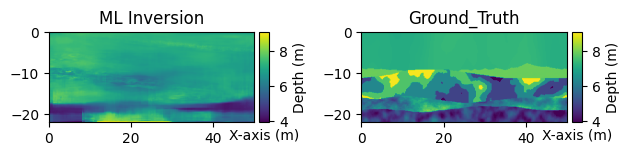

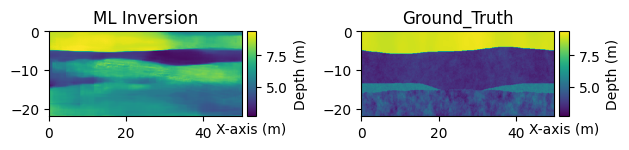

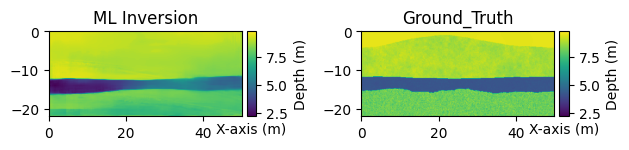

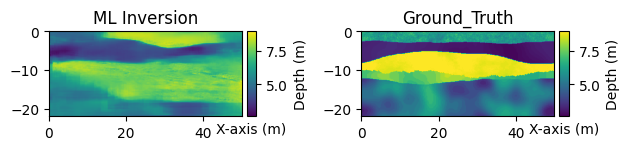

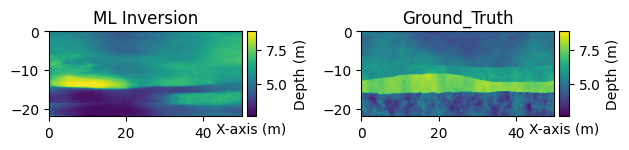

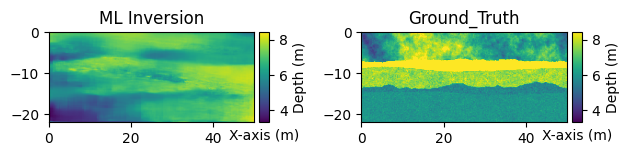

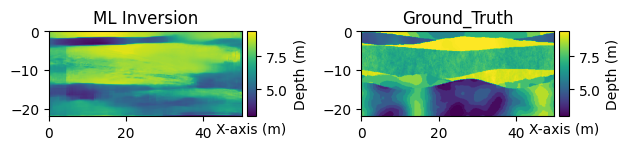

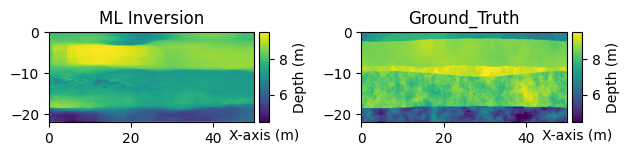

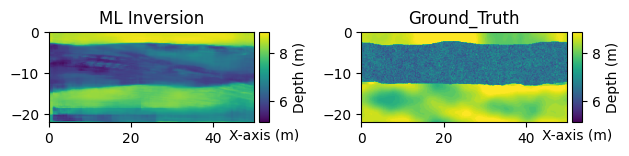

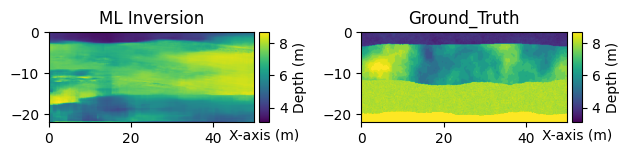

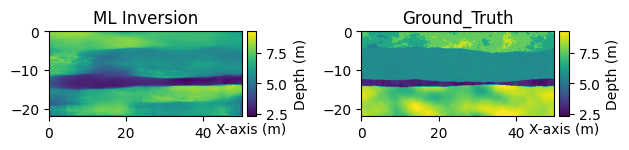

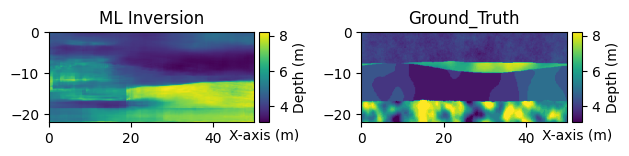

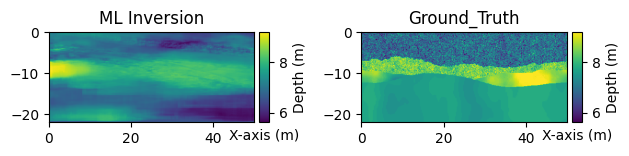

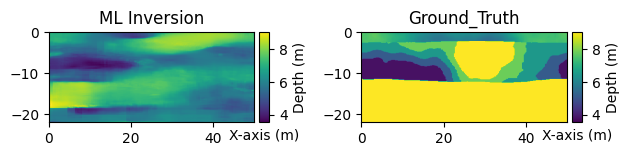

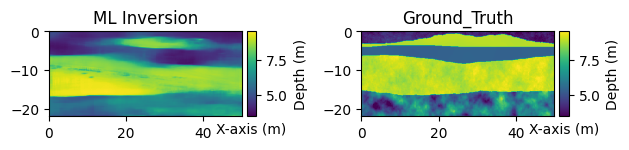

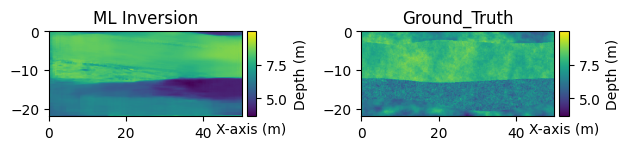

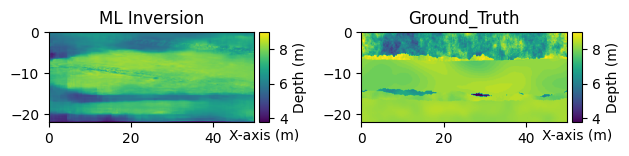

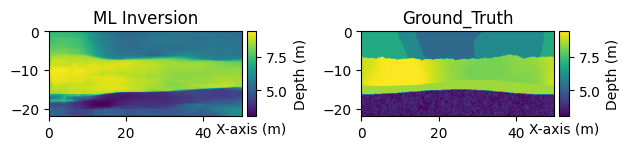

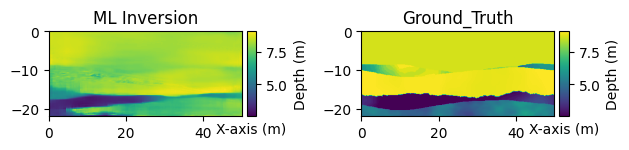

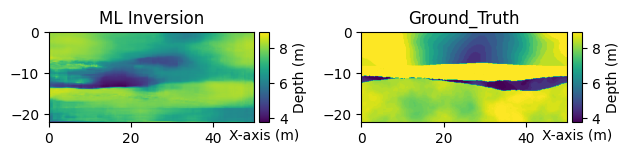

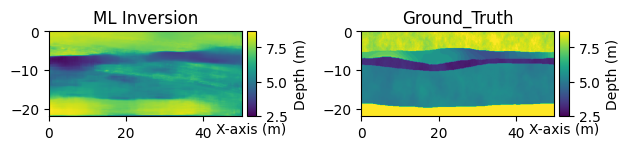

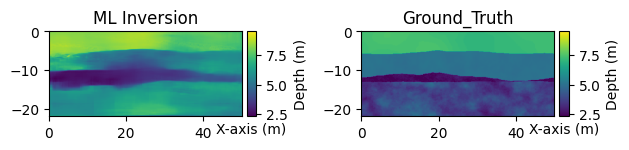

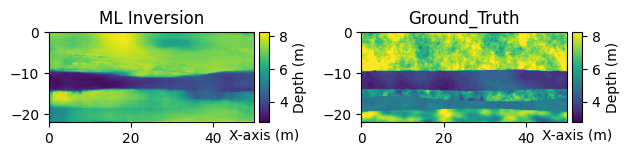

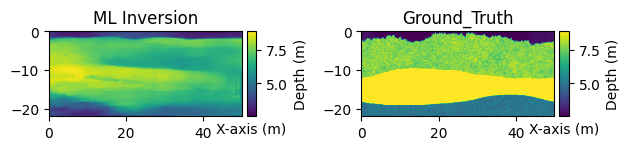

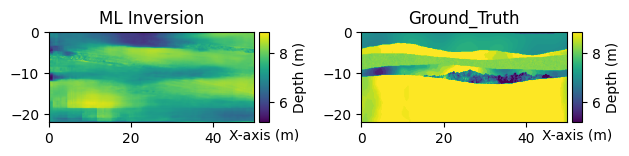

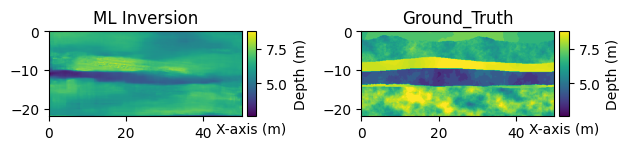

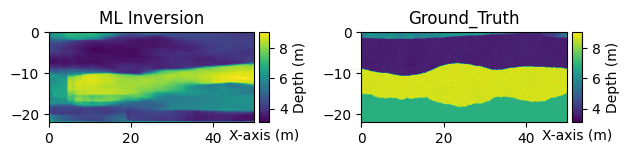

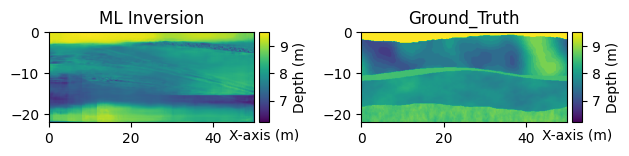

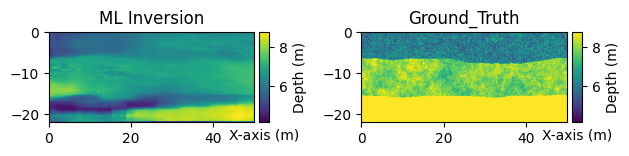

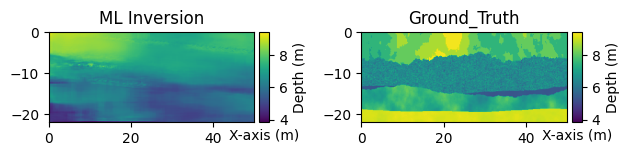

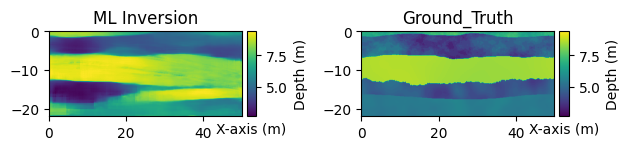

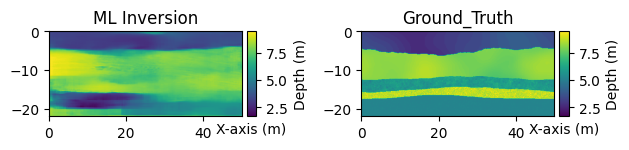

In [ ]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def custom_loss(y_true, y_pred):
    # Mean Absolute Error
    mae = tf.math.reduce_mean(tf.math.abs(y_true - y_pred))

    # Mean Absolute Differences
    # reg=tf.math.reduce_mean(tf.math.abs(y_pred[1:]-y_pred[:-1]))

    # return mae + reg*0.001

    return ma


x_test =  np.load('/content/drive/MyDrive/Evaluation_Full_Data.npy')
x_test = x_test[...,np.newaxis]

y_test = np.zeros((100,224,224))
for i in range(0,100):
    y_test[i,:,:] = np.load('/content/drive/MyDrive/Testing_Label/Testing_Model_{}.npy'.format(i))

y_test = y_test[...,np.newaxis]




saved_model = load_model('best_model_2_0.keras', custom_objects= {'custom_loss': custom_loss})


# Predictions using x_test. x_test are unknown data that were not included in the training process
predictions = saved_model.predict(x_test)


# # Load the best model
# for i in range(1,2):
#     saved_model = load_model('best_model_2_{}.hp5'.format(i), custom_objects= {'custom_loss': custom_loss})


#     # Predictions using x_test. x_test are unknown data that were not included in the training process
#     predictions = predictions + saved_model.predict(x_test)

predictions = predictions



# print(np.mean(np.abs( 10*(predictions+0.5) - 10*(y_test+0.5))))
print(np.mean(np.abs( 10*(predictions+0.5) - (y_test))))


# plot the results
for i, c in enumerate(predictions):
    sh = np.shape(c)

    # Actual size of the model i.e. 50x22 meters
    xc = np.linspace(0,50,sh[0])
    yc = np.linspace(0,22,sh[1])

    plt.subplot(1,2,1)
    ax = plt.gca()
    c = (c+0.5)*10
    im = ax.imshow(c, extent=[0, 50, -22, 0],vmin = c.min(), vmax = c.max())
    plt.title('ML Inversion')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.xlabel('X-axis (m)')
    plt.ylabel('Depth (m)')

    plt.subplot(1,2,2)
    ax = plt.gca()
    im = ax.imshow((y_test[i,:,:]), extent=[0, 50, -22, 0], vmin = c.min(), vmax = c.max())
    plt.title('Ground_Truth')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.xlabel('X-axis (m)')
    plt.ylabel('Depth (m)')
    plt.tight_layout()

    plt.show()


In [ ]:
import pandas as pd

predictions2 = np.squeeze(predictions, axis=-1)

predictions2 = (predictions2+0.5)*10

array_2d = predictions2.reshape(100, -1)

df = pd.DataFrame(array_2d)
df["Id"] = range(len(df))
df.set_index('Id', inplace=True)
df.to_csv('Testing_Labels_3.csv')
